In [68]:
# Import Libraries
from itertools import permutations
import numpy as np
import pandas as pd

#Data Preprocessing
from sklearn.preprocessing import LabelEncoder

#Exploratory Data Analysis & Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid") #set style for plots

from sklearn.manifold import TSNE

#Clustering Models
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram 

#Model Performance Assessment
from  sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support

#set seed
import random
random.seed(1999)


# Unsupervised Learning Problem 

Our goal is to find an unsupervised learning method that could accurately classify whether a patient has Hepatitis-C, and its progression, given the values of common labwork features. In particular, I will look at and compare three different clustering methods in order to determine which, if any, can act as a high-performing classifier given the labwork.

### Exploring the Dataset

The dataset we are using for this problem comes from the UC Irvine Machine Learning Repository and is called "HCV data". It was donated to the repository on June 9th, 2020 which makes it a fairly recent dataset. 

The dataset can be found here: https://archive.ics.uci.edu/dataset/571/hcv+data

We can see more about dataset by exploring it below:

In [2]:
df = pd.read_csv("hcvdat0.csv")
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [3]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB
None


,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


We can see from above that the dataset contains 615 samples and 12 feature columns. One of those feature columns appears to be erroneous. There is one 'target' column that notes whether the sample belongs to a blood donor without Hepatitis C or one with Hepatitis C. The target column also notes the progress of the viral infection by specifying "just Hepatitis C, Fibrosis, [or] Cirrhosis."

### Data Cleaning

There are multiple null values in our dataset that need to be addressed as well as an erroneous column, "Unnamed: 0", that arose from loading in the csv file.

Before we work with the data we need to remove the erroneous column and investigate the best way to deal with the null values.

In [4]:
#remove erroneous column
df= df.drop(columns=["Unnamed: 0"], axis=1)

#convert "Suspect Blood Donor" to "Blood Donor" category
df['Category'].mask(df['Category'] == '0s=suspect Blood Donor', '0=Blood Donor', inplace=True)

#convert sex column to categorical column
sex_encoder = LabelEncoder()
df['Sex'] = sex_encoder.fit_transform(df['Sex'])

#encode target column to integers
cat_encoder = LabelEncoder()
df['Category'] = cat_encoder.fit_transform(df['Category'])

df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,1,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [5]:
#filter out all clean rows so we can focus on rows
#with null values
null_rows = df[df.isnull().any(axis=1)]

null_rows.head(n=null_rows.shape[0])


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
121,0,43,1,48.6,45.0,10.5,40.5,5.3,7.09,NaN,63.0,25.1,70.0
319,0,32,0,47.4,52.5,19.1,17.1,4.6,10.19,NaN,63.0,23.0,72.2
329,0,33,0,42.4,137.2,14.2,13.1,3.4,8.23,NaN,48.0,25.7,74.4
413,0,46,0,42.9,55.1,15.2,29.8,3.6,8.37,NaN,61.0,29.0,71.9
424,0,48,0,45.6,107.2,24.4,39.0,13.8,9.77,NaN,88.0,38.0,75.1
433,0,48,0,46.8,93.3,10.0,23.2,4.3,12.41,NaN,52.0,23.9,72.4
498,0,57,0,48.4,94.4,2.5,39.6,2.3,8.84,NaN,82.0,6.4,76.8
540,1,38,1,45.0,56.3,NaN,33.1,7.0,9.58,6.0,77.9,18.9,63.0
541,1,19,1,41.0,NaN,87.0,67.0,12.0,7.55,3.9,62.0,65.0,75.0
545,1,29,1,49.0,NaN,53.0,39.0,15.0,8.79,3.6,79.0,37.0,90.0


In [6]:

# count the number of nulls in each column
print(null_rows.isnull().sum())

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


As can be seen above, the two columns with the most null values are ALP and CHOL. First, let's explore the null values in $ALP$, which contains the most null values in the dataset.

### Investigating ALP null values

Our choices for dealing with the null values are to remove the associated rows or to impute the null values found with the mean value of that column. Given the amount low amount of non-Blood Donor categories in the dataset it would be more ideal to impute the mean where possible. In order to impute the mean, we must first make sure that it would be reasonable to do so by looking at the associated distribution.

count    597.000000
mean      68.283920
std       26.028315
min       11.300000
25%       52.500000
50%       66.200000
75%       80.100000
max      416.600000
Name: ALP, dtype: float64


<Axes: xlabel='ALP'>

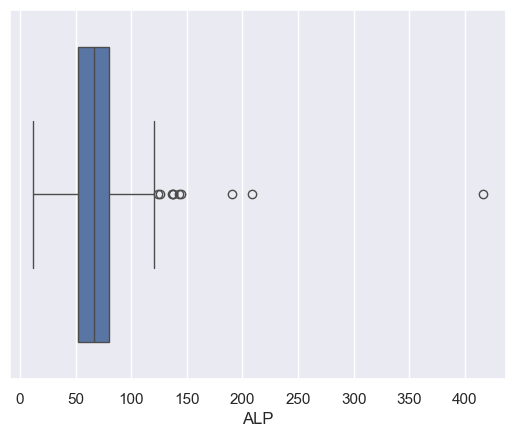

In [7]:
print(df['ALP'].describe())

sns.boxplot(x='ALP',data=df)

We can see from the printout and plot above that the data is centered at $68.284$ with some outliers. Before we impute the mean we should ensure that the outliers aren't associated with the target classification in a way that would skew our predictions if imputed.

We can isolate the values above the 75th percentile and compare the proportion of each category with the overall proportion of the dataset to see if there 

In [8]:
print("The proportions of categories in ALP values above 80.1 are:\n")
print(df[df['ALP'] > 80.100000].value_counts('Category', normalize=True))

The proportions of categories in ALP values above 80.1 are:

Category
0    0.906040
3    0.080537
1    0.013423
Name: proportion, dtype: float64


In [9]:
print("The proportions of categories in ALP values across the entire dataset are:\n")
df.value_counts('Category', normalize=True)

The proportions of categories in ALP values across the entire dataset are:



Category
0    0.878049
3    0.048780
1    0.039024
2    0.034146
Name: proportion, dtype: float64

We can see from the above that the proportions more or less match which suggests that outliers of ALP values do not have a strong correlation with category. With this knowledge in mind, we can impute the null values of ALP with the mean. 

### Investigating CHOL Null Values

We can repeat our methodology above to determine whether or not it would be reasonable to impute missing values for CHOL. 

count    605.000000
mean       5.368099
std        1.132728
min        1.430000
25%        4.610000
50%        5.300000
75%        6.060000
max        9.670000
Name: CHOL, dtype: float64


<Axes: xlabel='CHOL'>

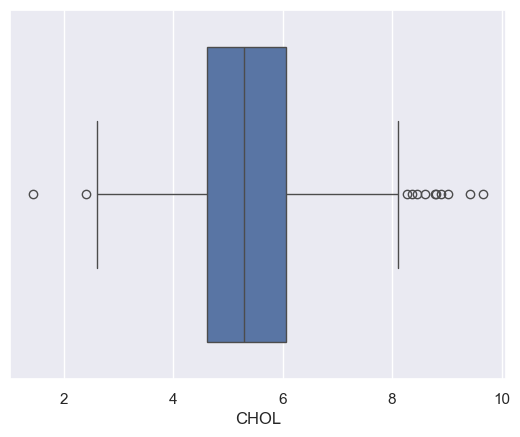

In [10]:
print(df['CHOL'].describe())

sns.boxplot(x='CHOL',data=df)

In [11]:
print("The proportions of categories in CHOL values above  6.06 are:\n")
print(df[df['CHOL'] >  6.06].value_counts('Category', normalize=True))

The proportions of categories in CHOL values above  6.06 are:

Category
0    0.953642
1    0.033113
2    0.006623
3    0.006623
Name: proportion, dtype: float64


In [12]:
print("The proportions of categories in CHOL values across the entire dataset are:\n")
df.value_counts('Category', normalize=True)

The proportions of categories in CHOL values across the entire dataset are:



Category
0    0.878049
3    0.048780
1    0.039024
2    0.034146
Name: proportion, dtype: float64

Likewise with ALP, the proportions are not far off enough to justify removal of rows with null values, especially considering the skewed dataset. 

#### A Note on ALB, ALT and PROT

Two rows contained a null value for either ALB or PROT. In both cases, the nulls appear in rows with 2 other null values. Given the amount of null values for that row it seemed pertinent to remove them rather than impute for all 3 features. 

In [13]:
#Remove all rows with 3 nulls 
three_null_indices = df[np.sum(df.isnull().astype(int),axis=1) >=3].index
cleaned_df = df.drop(index=three_null_indices)

#Impute means for CHOL, ALP, and ALT
cleaned_df['CHOL'] = cleaned_df['CHOL'].fillna(cleaned_df['CHOL'].mean())
cleaned_df['ALP'] = cleaned_df['ALP'].fillna(cleaned_df['ALP'].mean())
cleaned_df['ALT'] = cleaned_df['ALT'].fillna(cleaned_df['ALT'].mean())

#Review cleaned dataframe
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  613 non-null    int32  
 1   Age       613 non-null    int64  
 2   Sex       613 non-null    int32  
 3   ALB       613 non-null    float64
 4   ALP       613 non-null    float64
 5   ALT       613 non-null    float64
 6   AST       613 non-null    float64
 7   BIL       613 non-null    float64
 8   CHE       613 non-null    float64
 9   CHOL      613 non-null    float64
 10  CREA      613 non-null    float64
 11  GGT       613 non-null    float64
 12  PROT      613 non-null    float64
dtypes: float64(10), int32(2), int64(1)
memory usage: 62.3 KB


As can be seen above, there are no longer any non-null columns which allows us to proceed with exploratory data analysis.

## Exploring the Data

Now that we have clean data we can perform some exploratory data analysis (EDA) to investigate the dataset. I begin with looking at the distribution of the data via histograms. 

Text(0.5, 0.98, 'Distribution of Bloodwork Features')

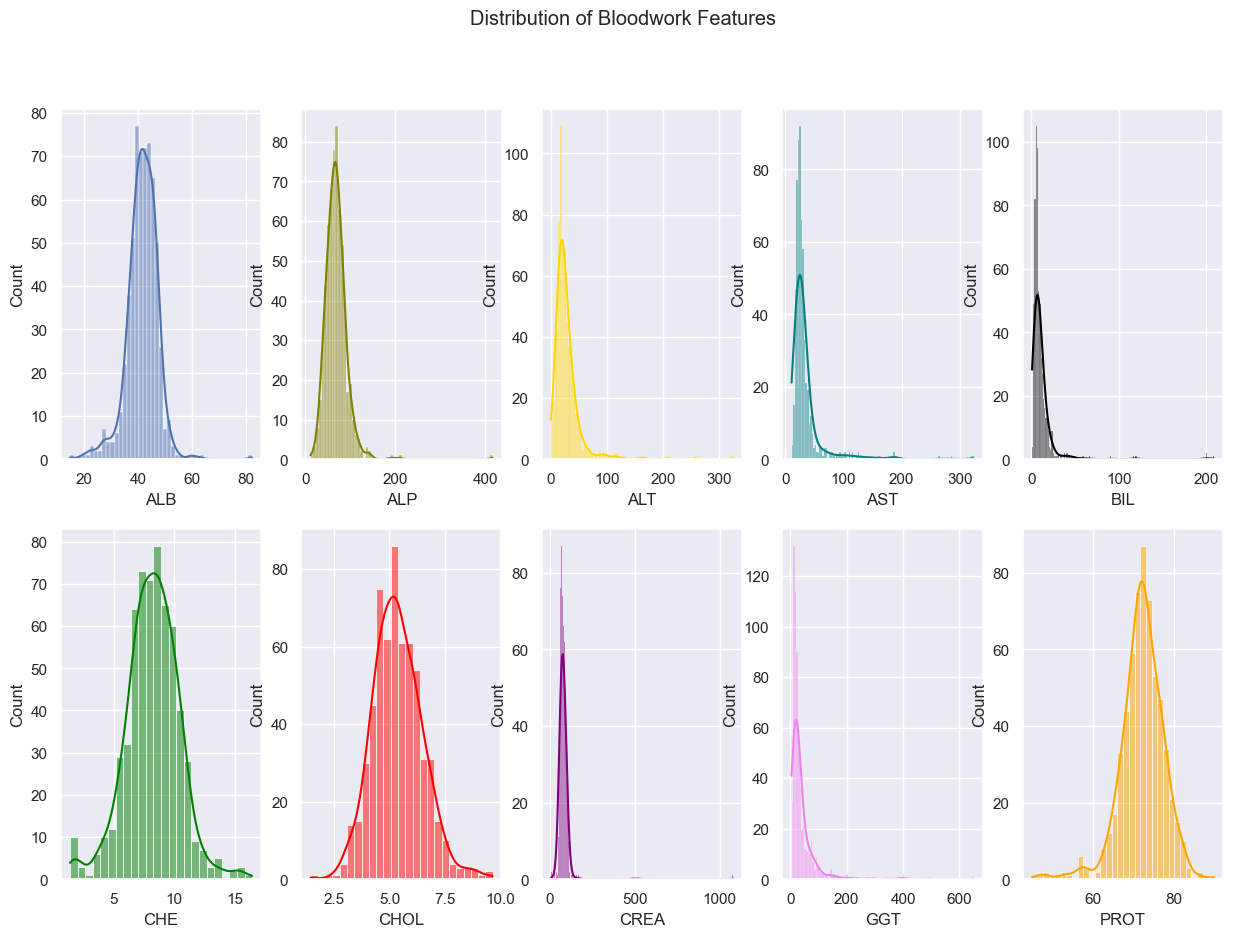

In [14]:

fig, axs = plt.subplots(2, 5, figsize=(15, 10))

sns.histplot(data=cleaned_df, x="ALB", kde=True, ax=axs[0, 0])
sns.histplot(data=cleaned_df, x="ALP", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=cleaned_df, x="ALT", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=cleaned_df, x="AST", kde=True, color="teal", ax=axs[0, 3])
sns.histplot(data=cleaned_df, x="BIL", kde=True, color="black", ax=axs[0, 4])
sns.histplot(data=cleaned_df, x="CHE", kde=True, color="green", ax=axs[1, 0])
sns.histplot(data=cleaned_df, x="CHOL", kde=True, color="red", ax=axs[1, 1])
sns.histplot(data=cleaned_df, x="CREA", kde=True, color="purple", ax=axs[1, 2])
sns.histplot(data=cleaned_df, x="GGT", kde=True, color="violet", ax=axs[1, 3])
sns.histplot(data=cleaned_df, x="PROT", kde=True, color="orange", ax=axs[1, 4])

plt.suptitle("Distribution of Bloodwork Features")

Reviewing the histograms above we can see that the CHE, CHOL, and PROT seem more or less normally distributed and centered while ALP, ALT, AST, BIL, CREA, and GGT are right-skewed. We can get a clearer sense of the distribution for the latter group using boxplots.

### Boxplots of ALP, ALT, AST, BIL, CREA, and GGT

Text(0.5, 0.98, 'Distribution of ALP, ALT, AST, BIL, CREA, and GGT')

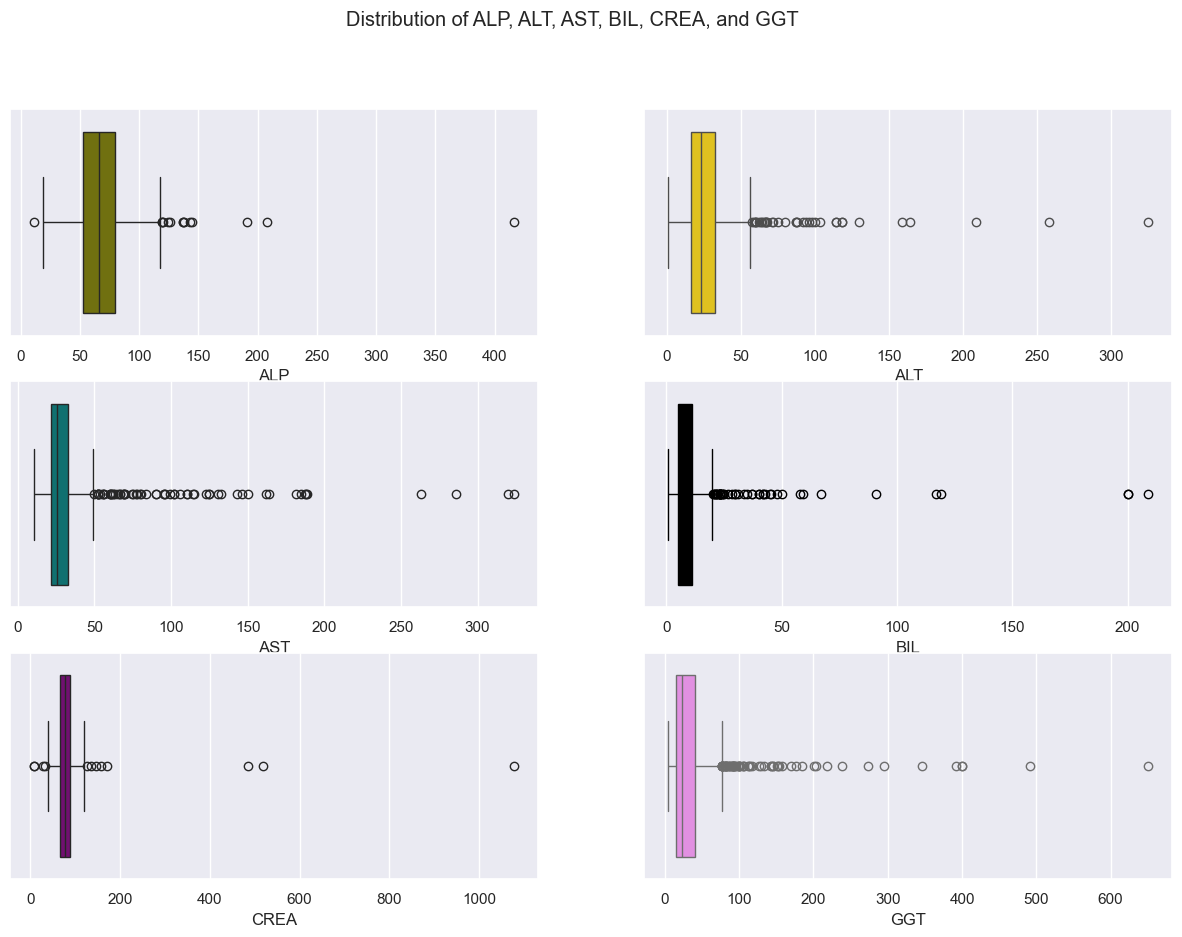

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

sns.boxplot(data=cleaned_df, x="ALP", color="olive", ax=axs[0, 0])
sns.boxplot(data=cleaned_df, x="ALT", color="gold", ax=axs[0, 1])
sns.boxplot(data=cleaned_df, x="AST", color="teal", ax=axs[1, 0])
sns.boxplot(data=cleaned_df, x="BIL", color="black", ax=axs[1, 1])
sns.boxplot(data=cleaned_df, x="CREA",color="purple", ax=axs[2, 0])
sns.boxplot(data=cleaned_df, x="GGT", color="violet", ax=axs[2, 1])

plt.suptitle("Distribution of ALP, ALT, AST, BIL, CREA, and GGT")

While all the distributions are right-skewed, as can be confirmed above, it is interesting to note that CREA only has three outliers are so far beyond the mean. It is possible that those data points are erroneous and that should be kept in mind. The same can be said of ALP. The other distributions have multiple outliers which appear to "stretch" out, suggesting that they may be associated with categories rather than being erroneous. 

To explore this idea, we can isolate GGT and visualize the boxplot by category value.

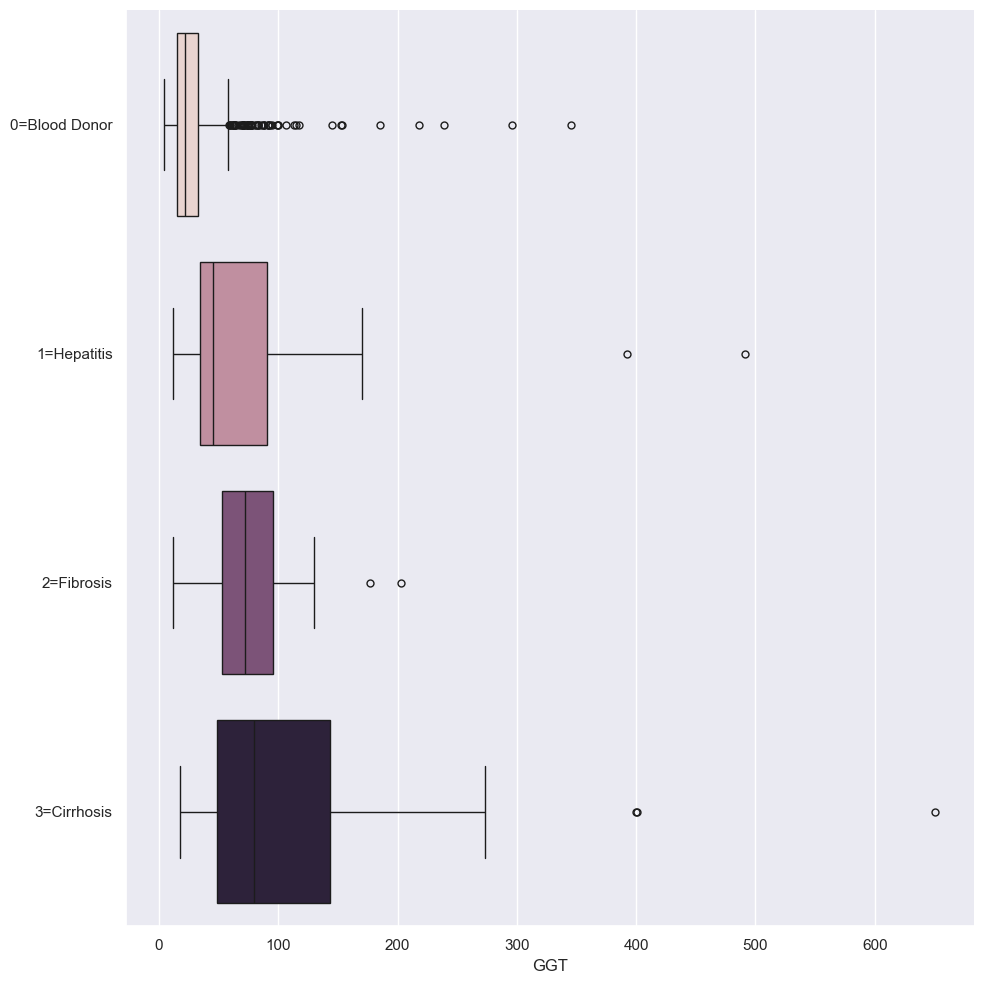

In [16]:

sns.catplot(data=cleaned_df, 
            kind="box",
            x="GGT", 
            y=cat_encoder.inverse_transform(cleaned_df["Category"]), 
            hue="Category",
            legend=False,
            height=10)



When accounting for target category, we can see that the target value changes the distribution of the data. The unsupervised learning methods we will employ can leverage this fact to cluster and classify the data points.

### Visualizing Correlation in Features 

[Text(0.5, 1.0, 'Correlation Among Features')]

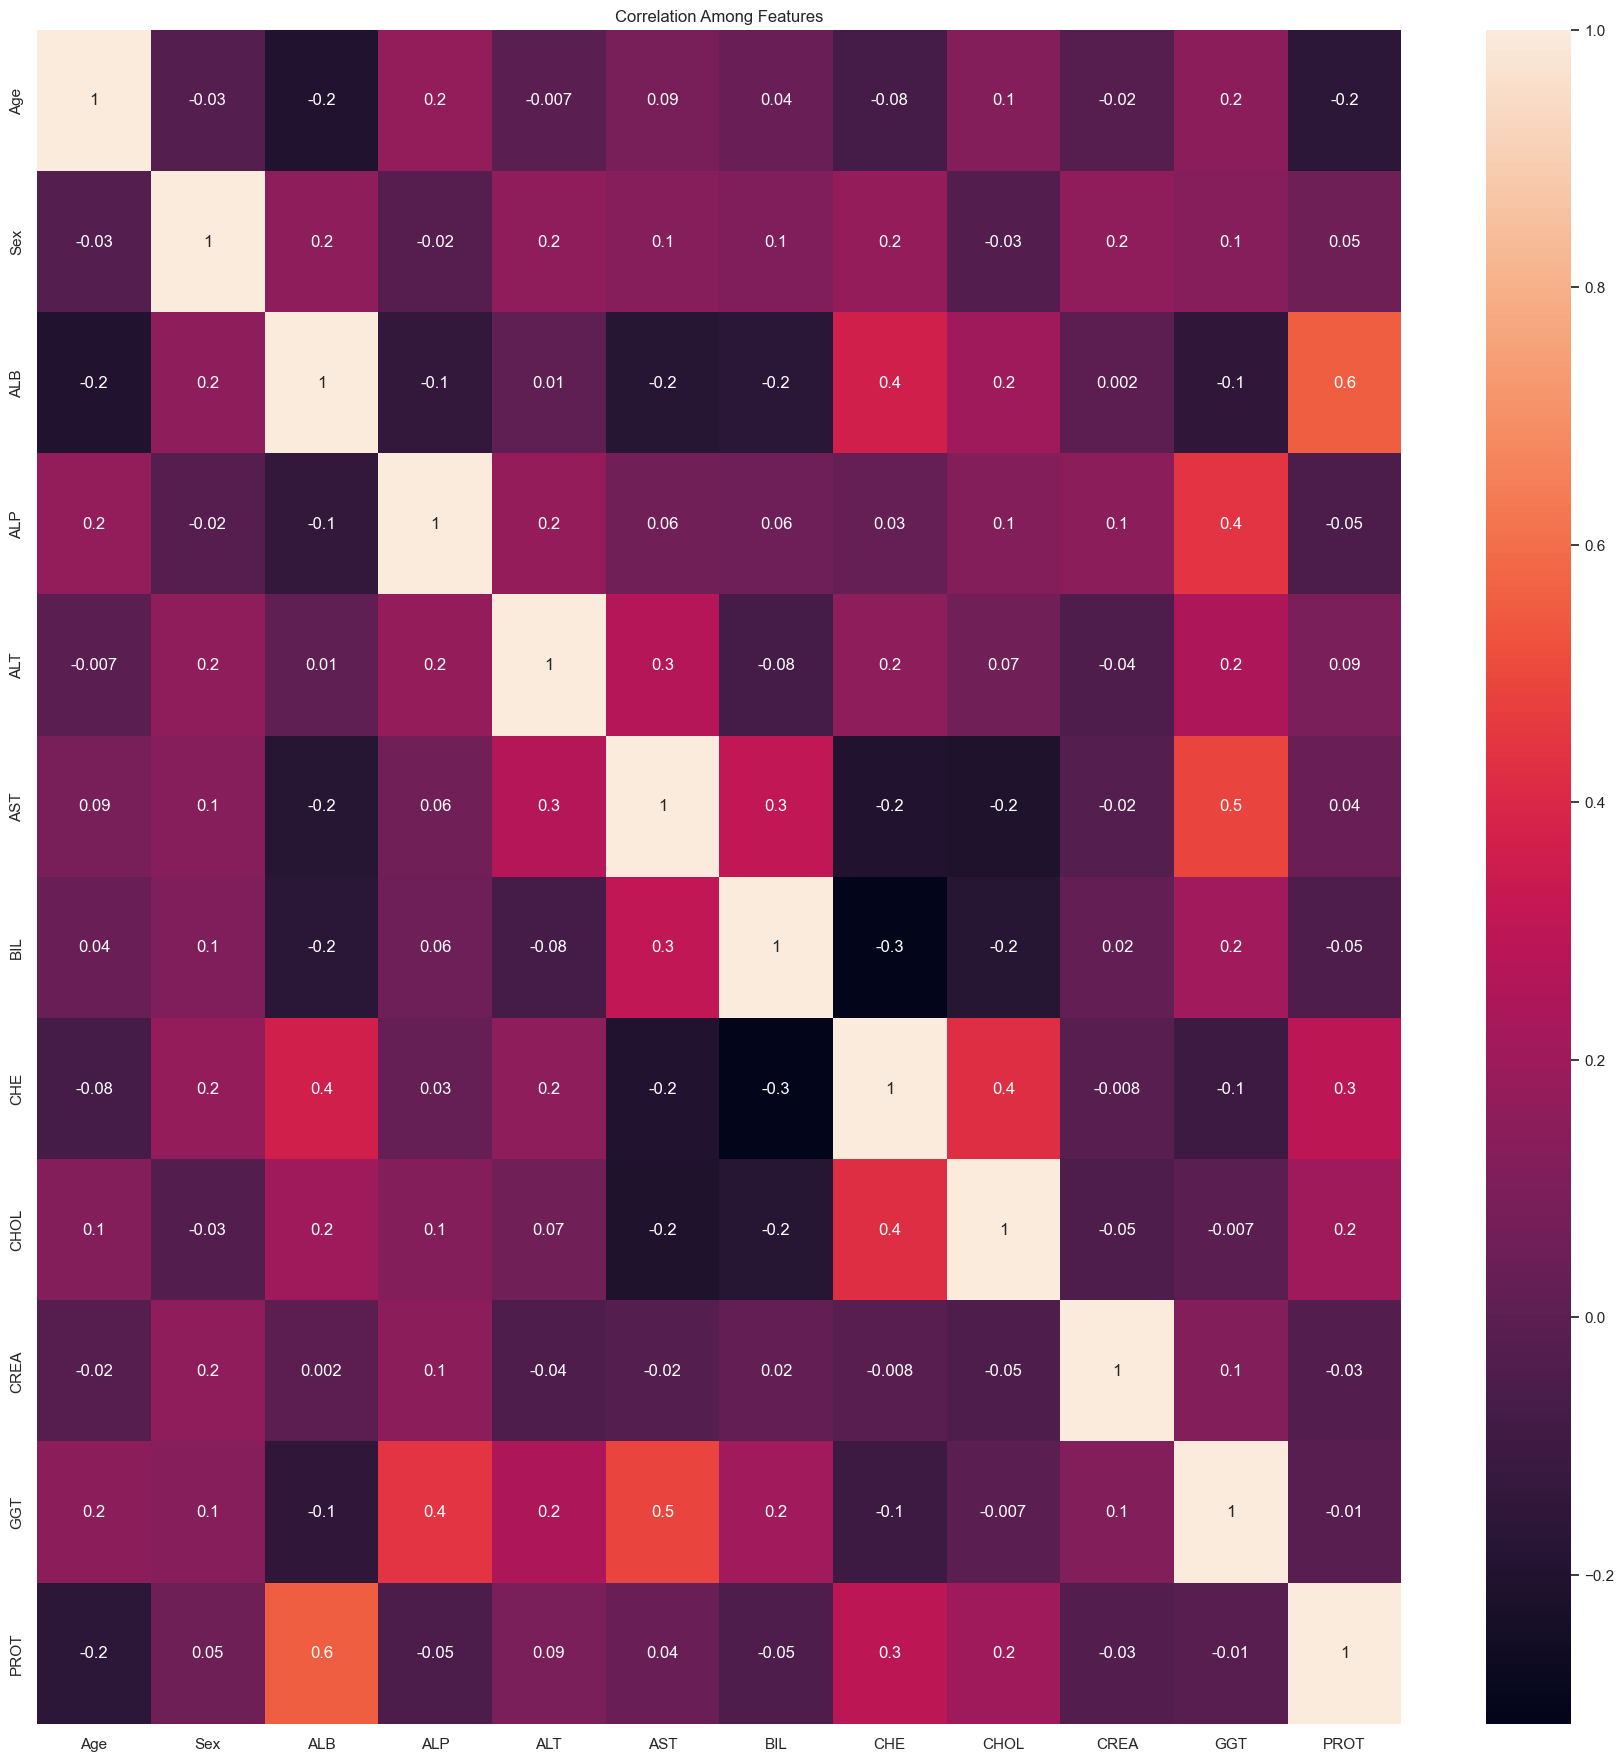

In [75]:
#look at correlation between features

width = 22
height = 22
sns.set(rc = {'figure.figsize':(width,height)})
sns.heatmap(data=cleaned_df.drop(columns=['Category']).corr(),  annot=True, fmt='.1g').set(
    title = "Correlation Among Features"
)

We can see from the above heatmap that there is not much correlation among features with the range of correlation to be generaly within -.3 - .5. There do not appear to be any feature correlations above .7 which suggests offhand that collinearity may not be a problem. Models that are particularly susceptical to problems with collinearity (e.g. logistic regression) therefore could theoretically be employed. Our clustering algorithms should be unaffacted.

### Visualizing Potential Clusters using Unsupervised Learning Techniques

We can use the unsupervised learning technique of T-SNE to visualize our data in a potential cluster. T-SNE performs a PCA dimensionality reduction on the data and projects the data points onto a 2D plane. This allows us to visualize a sense of neighborhood clustering for high dimensionality data. 

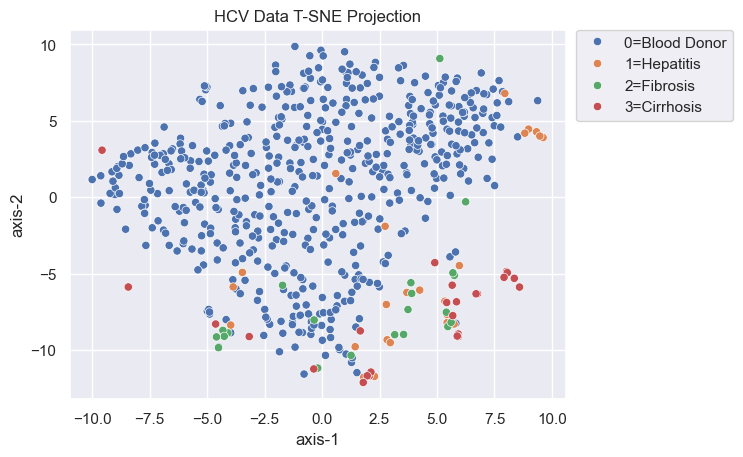

In [17]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='pca', perplexity=90, ).fit_transform(cleaned_df.drop(columns=['Category']))

df = pd.DataFrame()
df["y"] = cat_encoder.inverse_transform(cleaned_df['Category'])
df["axis-1"] = X_embedded[:,0]
df["axis-2"] = X_embedded[:,1]

sns.scatterplot(x="axis-1", y="axis-2", hue=df.y.tolist(),
                data=df).set(title="HCV Data t-SNE Projection") 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


Viewing the t-SNE projection above we can see that the various stages of Hepatitis C appear ot be clustered together but there is some difficulty in separating out the intra-clusters within the non-blood donors. This suggests that we may have difficulty separating categories 1, 2, and 3 while our clustering methods may find it easire to separate out category 0 from all the others. 

## Utilizing Unsupervised Learning Methods to Classify Data

In [18]:
#split data into train and test sets
clean_y = cleaned_df['Category']
clean_X = cleaned_df.drop(columns=["Category"])

X_train, X_test, y_train, y_test = train_test_split(clean_X, clean_y, test_size=.2, random_state=1999)

Unsupervised learning methods are unaware of the "true" categories associated with the dataset so we will need to write a function that can fit the randomly chosen labels produced by the model to the true category data. We can do so by permuting through all possible combinations of label fittings and return the one associated with the highest accuracy.

GridSearchCV is a class provided by sklearn that can perform a grid search to find the best model from multiple hyperparameters by performing 5-fold cross validation against a chosen metric. In order to utilize GridSearchCV we need to format our custom metric as below.

In [19]:
## Create custom scorer for GridSearch 

def perm_acc(true_labels, predicted_labels):
    """
    Scorer function to compare cluster accuracy
    for cross validation.
    """
    labels = np.unique(true_labels)

    #permute all possible combinations
    perms = [i for i in permutations(range(4))]

    #initialize best_accuracy and labels for iterative comparisons
    best_accuracy = .00
    best_labels = (0,0,0,0,0)
    
    all_accuracy = []
    
    for perm in perms:
        labels_assigned = [labels[x] for x in perm]

        correct_pred = 0
        all_else = 0

        true_labels_list = list(true_labels)
        for i, label in enumerate(true_labels_list):
            if labels_assigned[predicted_labels[i]] == label:
                correct_pred += 1
            else:
                all_else +=1
                
        acc = correct_pred / (correct_pred + all_else)
        all_accuracy.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
    
    return best_accuracy

#initialize scorer
perm_acc_scorer_ = make_scorer(perm_acc)

#GridSearchCV requires estimator to have a predict method. 
#Create class wrappers to return clustering labels when 
#predict method is called

class AgglomerativeClusteringWrapper(AgglomerativeClustering):
    
    def predict(self,X):
      return self.labels_.astype(int)
    

class DBSCANWrapper(DBSCAN):
    
    def predict(self,X):
      return self.labels_.astype(int)
    
class KMeansWrapper(KMeans):

    def predict(self, X):
        return self.labels_.astype(int)
    

Now that we have written our custom scorer and wrappers we can perform a grid search to find the models which result in the highest accuracy after 5-fold cross validation.

## Hierarchical Clustering Method

In [20]:
#Ward linkage can only work with euclidean metric. During the grid search
#warnings will appear when other combinations with ward are attempted.
#The below suppresses the warnings as they are expected and erroneous
#to our problem

import warnings
warnings.filterwarnings('ignore')


num_labels = len(y_train.unique())
h_cluster = AgglomerativeClusteringWrapper(n_clusters=num_labels, 
                                    compute_distances=True) #for dendrogram plots

#define parameters to tune
h_cluster_params = {
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'linkage': ['ward', 'complete', 'average', 'single']
}


hclf = GridSearchCV(h_cluster, param_grid=h_cluster_params, scoring=perm_acc_scorer_)
hclf.fit(X_train, y_train)

#assign best estimator
best_heir_cluster = hclf.best_estimator_

print("The clustering parameters associated with the highest accuracy are: ")
print(hclf.best_params_)
print(f"The accuracy achieved is {hclf.best_score_}")

The clustering parameters associated with the highest accuracy are: 
{'linkage': 'single', 'metric': 'euclidean'}
The accuracy achieved is 0.863265306122449


### Reviewing the Hierarchical Cluster and Dendrogram Plot

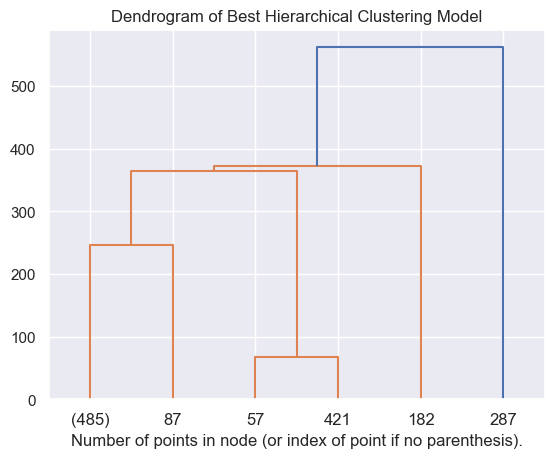

In [21]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Helper function taken from scikit-learn 
    # Plot Hierarchical Clustering Dendrogram tutorial
    #https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Dendrogram of Best Hierarchical Clustering Model")
# plot the top three levels of the dendrogram
plot_dendrogram(best_heir_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Reviewing the plotted dendrogram above we can see that the second orange clusterings, which contain the majority of the nodes, are the most similar. The fact that the majority of the nodes appear in one cluster and only single indices appear in the others highlights the difficulty with working with imbalanced data as we are where the vast majority of samples are associated with Blood Donors and only a relative few are associated with the other categories. 

An accuracy of .86 is not particularly high given the imbalanced dataset. We can see if other clustering methods perform better.

## DBScan Clustering

In [22]:
db_cluster = DBSCANWrapper()

#define parameters to tune
db_cluster_params = {
    'eps': np.arange (.01, .9, .01),
    'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


dbclf = GridSearchCV(db_cluster, param_grid=db_cluster_params, scoring=perm_acc_scorer_, n_jobs=-1)
dbclf.fit(X_train, y_train)

#assign best estimator
best_db_cluster = dbclf.best_estimator_

print("The clustering parameters associated with the highest accuracy are: ")
print(dbclf.best_params_)
print(f"The accuracy achieved is {dbclf.best_score_}")

The clustering parameters associated with the highest accuracy are: 
{'algorithm': 'auto', 'eps': 0.01, 'metric': 'euclidean'}
The accuracy achieved is 0.8775510204081632


### Reviewing DBScan



[Text(0.5, 1.0, 'DBScan Epsilon Parameter Tuning'),
 Text(0.5, 0, 'Epsilon parameter'),
 Text(0, 0.5, 'Mean Accuracy')]

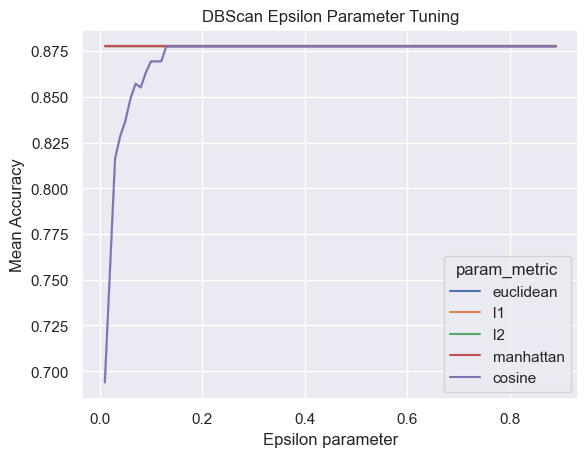

In [23]:
dbscan_results = pd.DataFrame(dbclf.cv_results_)

sns.lineplot(x="param_eps", y="mean_test_score", hue="param_metric", data=dbscan_results).set(
    title='DBScan Epsilon Parameter Tuning',
    xlabel='Epsilon parameter',
    ylabel='Mean Accuracy'
)

Reviewing the above, the epsilon parameter appeared to have a significant impact on models using the cosine metric until around .1 after which the accuracy plateaued. The other metrics all appear to be largely unaffected by the epsilon parameter tuning. 

The accuracy of the DBScan clustering performs marginally better than the hierarchical clustering but it is still below expectations.

## Kmeans Clustering

In [24]:
kmeans_cluster = KMeans(n_clusters=4, random_state=1999)

#define parameters to tune
km_cluster_params = {
        'tol': np.arange(.00001, .009, .00001),
        'algorithm': ['lloyd', 'elkan', 'auto', 'full']
}


kmclf = GridSearchCV(kmeans_cluster, param_grid=km_cluster_params, scoring=perm_acc_scorer_, n_jobs=-1)
kmclf.fit(X_train, y_train)

#assign best estimator
best_km_cluster = kmclf.best_estimator_

print("The clustering parameters associated with the highest accuracy are: ")
print(kmclf.best_params_)
print(f"The accuracy achieved is {kmclf.best_score_}")

The clustering parameters associated with the highest accuracy are: 
{'algorithm': 'lloyd', 'tol': 0.00638}
The accuracy achieved is 0.8693877551020408


### Reviewing Kmeans Clustering


[Text(0.5, 1.0, 'KMeans Tolerance Parameter Tuning'),
 Text(0.5, 0, 'Tolance parameter'),
 Text(0, 0.5, 'Mean Accuracy')]

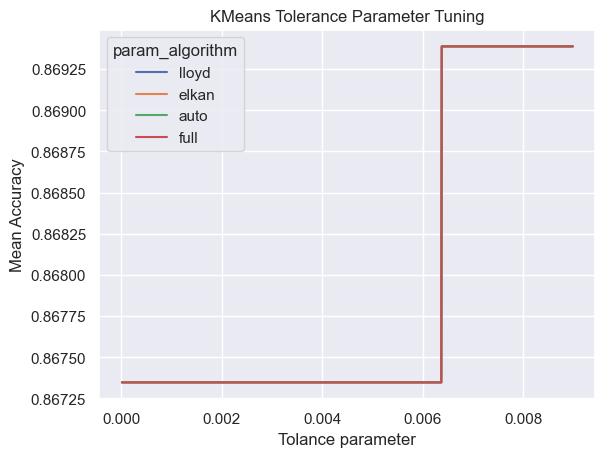

In [25]:
kmeans_results = pd.DataFrame(kmclf.cv_results_)

sns.lineplot(x="param_tol", y="mean_test_score", hue="param_algorithm", data=kmeans_results).set(
    title='KMeans Tolerance Parameter Tuning',
    xlabel='Tolance parameter',
    ylabel='Mean Accuracy'
)


Reviewing the parameter tuning, we can see that the tolerance parameter had an effect on all algorithms a little after .006, after which it no longer affected accuracy. All the algorithms appeared to return identical accuracy scores.

The accuracy score of the best kmeans model is in line with the other clustering parameters but does not achieve the best score of the three.

We can review the cross validation scores of all 3 clustering methods below.



In [26]:
cluster_df = pd.DataFrame(columns=['Mean Accuracy on Validation Set'])
cluster_df.loc['Heirarchical'] = hclf.best_score_
cluster_df.loc['DBScan'] = dbclf.best_score_
cluster_df.loc['Kmeans'] = kmclf.best_score_

cluster_df.sort_values(by=['Mean Accuracy on Validation Set'], ascending=False)

,Mean Accuracy on Validation Set
DBScan,0.877551
Kmeans,0.869388
Heirarchical,0.863265


While all three models returned similar accuracy scores on the validation set we can see that the DBScan clustering methods maintained the best accuracy score of ~ $.878$. 

### Performance of Clustering-based Predictions on Test Set

Now we can compare our three clustering methods' on the test set.

In [27]:
def label_permute_compare(true_labels,predicted_labels,n=4):
    """
    This is a helper function that will permute over all
    combinations of categories and test accuracy of NMF
    to see which combination of categories fits best.

    true_labels: labels dataframe object
    predicted_labels: label prediction output
    Returns permuted label order and accuracy. 

    """
   
    labels = np.unique(true_labels)
    #permute all possible combinations
    perms = [i for i in permutations(range(n))]

    #initialize best_accuracy and labels for iterative comparisons
    best_accuracy = .00
    best_labels = (0,0,0,0,0)
    
    all_accuracy = []
    
    for perm in perms:
        labels_assigned = [labels[x] for x in perm]

        correct_pred = 0
        all_else = 0

        true_labels_list = list(true_labels)
        for i, label in enumerate(true_labels_list):
            if labels_assigned[predicted_labels[i]] == label:
                correct_pred += 1
            else:
                all_else +=1
                
        acc = correct_pred / (correct_pred + all_else)
        all_accuracy.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_labels = perm
    
    print(f"The classification with the highest accuracy ({best_accuracy}) is: \n")

    for i in best_labels:
        print(f"{i} = {labels[i]}")
    print("")
    return best_labels, best_accuracy




### Heirarchical Cluster Performance on Test Set

The classification with the highest accuracy (0.9105691056910569) is: 

0 = 0
1 = 1
2 = 2
3 = 3



<Axes: >

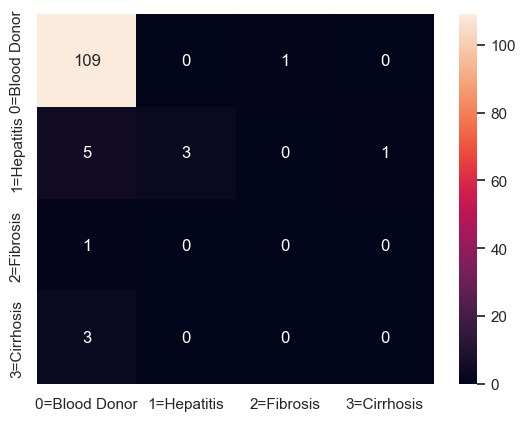

In [28]:
best_heir_cluster.fit(X_test)

heir_pred = best_heir_cluster.labels_
heir_labels, heir_accuracy = label_permute_compare(y_test, heir_pred)

labels = cat_encoder.inverse_transform([0, 1, 2, 3])

conf_matrix = confusion_matrix(y_test, heir_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g',
            xticklabels=labels,
            yticklabels=labels)


### Reviewing Heirarchical Clustering

We can see from the confusion matrix that even though the accuracy on the test set improved the model did not perform well as a classifier missing all cases of Cirrhosis and Fibrosis and only successfully predicting 3 cases of Hepatitis. It is clear from the confusion matrix that Heirarchical clustering alone cannot solve the classification problem

### DBScan Performance on Test set

The classification with the highest accuracy (0.8943089430894309) is: 

1 = 1
2 = 2
3 = 3
0 = 0



<Axes: >

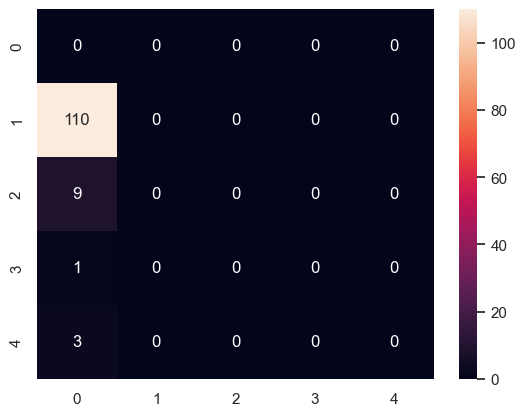

In [29]:
best_db_cluster.fit(X_test)

db_pred = best_db_cluster.labels_
db_labels, db_accuracy = label_permute_compare(y_test, db_pred)

conf_matrix = confusion_matrix(y_test, db_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')


As can be seen above, the DBScan clustering model created 5 clusters as opposed to the 4 for this problem. Additionally, it appears to give largely erroneous predictions and primarily benefited from the imbalanced nature of the data. It can be clear that in spite of the accuracy score metric it is not a good model.

### Kmeans Performance on Test Set

The classification with the highest accuracy (0.7560975609756098) is: 

0 = 0
2 = 2
3 = 3
1 = 1



<Axes: >

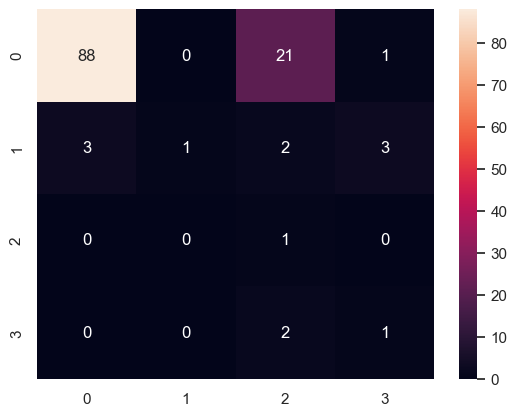

In [30]:
best_km_cluster.fit(X_test)

km_pred = best_km_cluster.labels_
km_labels, km_accuracy = label_permute_compare(y_test, km_pred)

conf_matrix = confusion_matrix(y_test, km_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')


Similarly to DBScan, the Kmeans clustering model appears to have benefited from the imbalanced nature of the data resulting in an inflated accuracy score. It however does not perform well compared to the Heirarchical clustering method.

We can see a breakdown of the precision, recall, and F1 scores of all 3 models below. 





In [31]:
df_compare = pd.DataFrame(columns=["Precision", "Recall", "F1", "Support"])
df_compare.loc['Heirarchical Cluster'] = precision_recall_fscore_support(y_test, heir_pred,average='weighted')
df_compare.loc['DBScan'] = precision_recall_fscore_support(y_test, db_pred,average='weighted')
df_compare.loc['Kmeans'] = precision_recall_fscore_support(y_test, km_pred, average='weighted')

df_compare = df_compare.drop(columns=['Support'])

df_compare.sort_values(by=['F1'], ascending=False)

,Precision,Recall,F1
Heirarchical Cluster,0.899270,0.910569,0.89167
Kmeans,0.943188,0.739837,0.80441
DBScan,0.000000,0.000000,0.00000


# Conclusions and Next steps

Precision, Recall, and F1 scores present a more meaningful look of the performance of our clustering methods on the test data. 

The F1 score, which presents a balance between recall and precision offers us an alternative way of evaluating the clustering models' performance. The Heirarchical cluster remains the best performing model with an F1 score of $.892$, providing further confidence in our previous evaluation. The DBScan is shown to be a completely erroneous model so we can safely ignore it. KMeans ofers a higher precision but a much lower recall. 

Heirarchical clustering therefore provides the best performance on the classification task we sought to solve.


### Improving the Classifiers

It is clear from our testing that the imbalanced nature of the dataset likely interfered with the ability for the models to effectively cluster the data. For imbalanced datasets such as the one in this problem it might be beneficial to use models that are more resilient to data imbalance such as decision trees. 

It might also be beneficial to combine all the non blood donor categories that mark the progression of Hepatitis-C into one category, "Hepatitis-C". This may help to reduce the class imbalance of the problem.

Finally, it may be beneficial to ensemble the clustering classifier with other classifiers, including potentially supervised learning methods such as logistic regression, in order to improve the F1 score.


### References

HCV Data. UCI Machine Learning Repository. (2023). https://archive.ics.uci.edu/dataset/571/hcv+data 

Plot hierarchical clustering dendrogram. scikit. (2023). https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html 

Wattenberg, M., Viégas, F., &amp; Johnson, I. (2016, October 13). How to use T-Sne effectively. Distill. https://distill.pub/2016/misread-tsne/ 